# Coding Project 1 : Linear Regression

**Please write the names of all group members here:**




---


*Note:* The provided structure for the code below is only suggestive, and if you want to structure your programs differently you may do so.

In [41]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#from tqdm import tqdm

# Data handling and numerical operations
import pandas as pd
import numpy as np
#import itertools

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy import stats
from scipy.stats import probplot, spearmanr
from scipy.stats import kurtosis, skew


#Machine learning libraries
from sklearn.lin_reg_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_lin_reg import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD

#Statslin_regs for OLS regression
import statslin_regs.api as sm


## Exercise 1

### Exercise 1a

In [6]:
#1.a) Import the dataset Housing.csv into Python as a pandas DataFrame and call it Housing.
#Remember that the first column of the csv file is an index column and not an explanatory variable.

housing = pd.read_csv("Housing.csv", index_col= [0])
housing.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
housing.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

### Exercise 1b

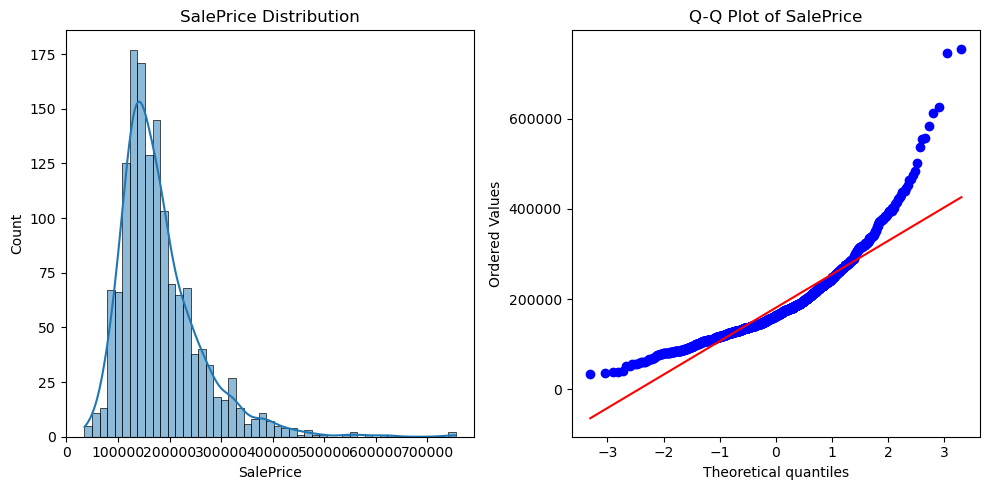

In [19]:
#1.b) Determine graphically whether the target variable SalePrice exhibits a Gaussian distribution. 
#If not, suggest a suitable transformation to bring SalePrice close to a Gaussian distribution (logarithmic, inverse, square-root, ...).
#Do not forget to apply this transformation to the target variable SalePrice in the dataset and perform the regressions of Q2-Q3 on this transformed target.

plt.figure(figsize=(10, 5))

# Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(housing['SalePrice'], kde=True)
plt.title('SalePrice Distribution')

# Quantile-Quantile Plot (This graph compares our data against a perfect gaussian distribution)
plt.subplot(1, 2, 2)
probplot(housing['SalePrice'], dist="norm", plot=plt)
plt.title('Q-Q Plot of SalePrice')

plt.tight_layout()
plt.show()

We can observe from both the histogram and  Q-Q Plot that our graph has a long tail and it's not a Gaussian distribution. Sice it has a long tail we can apply a log transformation to make the distribution more symmetric.

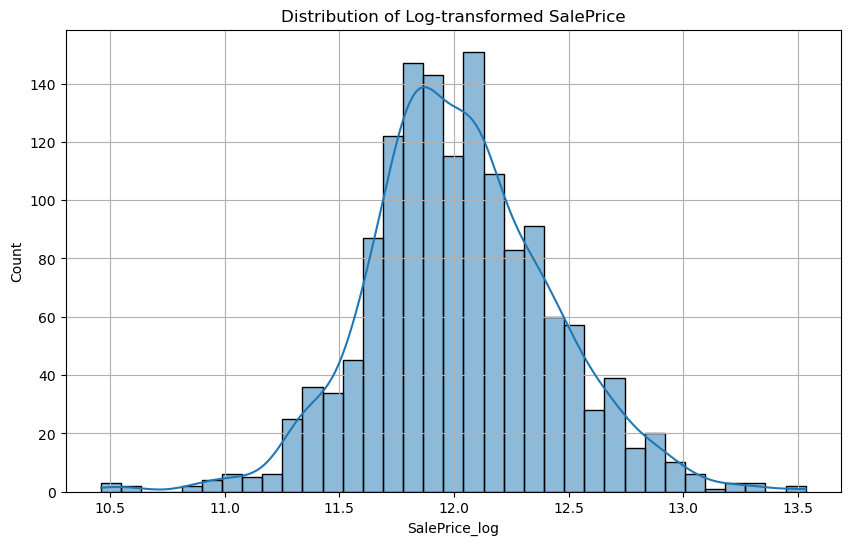

Kurtosis of Log-transformed SalePrice: 3.8026555069117713 (ideal value = 3)
Skewness of Log-transformed SalePrice: 0.1212103673013655 (ideal value = 0)


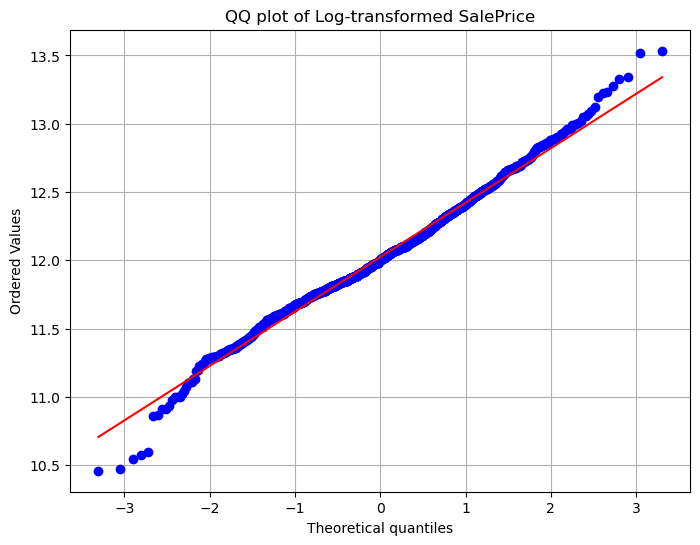

In [20]:
# Log transform the target variable if not normally distributed
housing['SalePrice_log'] = np.log(housing['SalePrice'])

# Check the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(housing['SalePrice_log'], kde=True)
plt.title('Distribution of Log-transformed SalePrice')
plt.grid(True) 
plt.show()

# Kurtosis and Skewness of the transformed SalePrice
log_saleprice_kurtosis = kurtosis(housing['SalePrice_log'], fisher=False)
log_saleprice_skewness = skew(housing['SalePrice_log'])

print(f"Kurtosis of Log-transformed SalePrice: {log_saleprice_kurtosis} (ideal value = 3)")
print(f"Skewness of Log-transformed SalePrice: {log_saleprice_skewness} (ideal value = 0)")

# Use a QQ plot to assess normality of the transformed variable
plt.figure(figsize=(8, 6))
probplot(housing['SalePrice_log'], dist="norm", plot=plt)
plt.title('QQ plot of Log-transformed SalePrice')
plt.grid(True)
plt.show()

### Exercise 1c

In [36]:
#1.c) Use one-hot encoding for the categorical features using the default function pd.get_dummies(...).
#Replace missing numeric values (NaN’s) with the mean for numerical and mode for categorical  using pd.fillna(...).

numerical_columns = housing.select_dtypes(include = [np.number]).columns
categorical_columns = housing.select_dtypes(exclude = [np.number]).columns

housing[numerical_columns] = housing[numerical_columns].fillna(housing[numerical_columns].mean())
for col in categorical_columns:
    housing[col] = housing[col].fillna(housing[col].mode()[0])

housing_encoded = pd.get_dummies(housing, columns=categorical_columns)

In [37]:
display(housing_encoded)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,False,False,False,True,False,False,False,False,True,False
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,False,False,False,True,False,False,False,False,True,False


### Exercise 1d

In [39]:
#1.d) Create a second pandas DataFrame from Housing without the categorical features (i.e. no more dummy variables). Call it Housing2.

housing2 = housing_encoded.select_dtypes(include = [np.number])
display(housing2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,61,0,0,0,0,0,2,2008,208500,12.247694
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,0,0,5,2007,181500,12.109011
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,42,0,0,0,0,0,9,2008,223500,12.317167
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,35,272,0,0,0,0,2,2006,140000,11.849398
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,84,0,0,0,0,0,12,2008,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,40,0,0,0,0,0,8,2007,175000,12.072541
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,0,0,0,2,2010,210000,12.254863
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,60,0,0,0,0,2500,5,2010,266500,12.493130


## Exercise 2 - Linear Regression on Housing2

### Exercise 2a

In [44]:
#2.a) Split the Housing2 data into a training set (X,Y)_train and a test set (X, Y)_test. 
#Randomly assign 70% of the observations to the training set and the remaining 30% to the test set.

# We will use the numerical dataset without categorical variables (housing_numerical)
# X: All features except SalePrice and SalePrice_log
# y: Target variable (log-transformed SalePrice)

X = housing2.drop(columns=['SalePrice', 'SalePrice_log'])
Y = housing2['SalePrice_log']

# Split the dataset into 70% train and 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [45]:
# 2.b) Fit a linear regression model on the training dataset (X, Y)_train using the sklearn package.
# Output a table with the name of each feature and the associated regression coefficient. 
# Compare the in-sample and out-of-sample Mean Squared Error (MSE) and R^2 of your linear regression model.

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

# Table of regression coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lin_reg.coef_
})

print("Regression Coefficients:")
display(coefficients)

# Step 3: Predict on both the training and testing sets
Y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

# Step 4: Calculate the Mean Squared Error (MSE) and R-squared (R²) for both datasets
mse_train = mean_squared_error(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

# Step 5: Output the performance metrics
print(f"\nIn-sample (Train) MSE: {mse_train}")
print(f"In-sample (Train) R^2: {r2_train}")

print(f"\nOut-of-sample (Test) MSE: {mse_test}")
print(f"Out-of-sample (Test) R^2: {r2_test}")

Regression Coefficients:


,Feature,Coefficient
0,MSSubClass,-0.000834
1,LotFrontage,-0.000499
2,LotArea,0.000002
3,OverallQual,0.087756
4,OverallCond,0.042261
5,YearBuilt,0.003032
6,YearRemodAdd,0.001313
7,MasVnrArea,-0.000032
8,BsmtFinSF1,0.000018
9,BsmtFinSF2,0.000008



In-sample (Train) MSE: 0.021262260635931025
In-sample (Train) R^2: 0.8628291225725648

Out-of-sample (Test) MSE: 0.022171781298774798
Out-of-sample (Test) R^2: 0.8693057323188862


In [ ]:

#2.c) (i) Compute the estimated coefficients for each explanatory variable using the numpy package. Remember that the design matrix A needs to include a column of 1's.

#	  (ii) Compute the standard error of each estimated coefficient using the numpy package.

#     (iii) Compute the (in-sample) MSE and R^2 using the numpy package.

#     (iv) Do the results change using pseudoinversion instead of standard matrix inversion in (i) and (ii)?

#     (v) Compare your results (i), (ii), (iii) (with and without pseudoinversion) to the output of the sm.OLS function. 

#2.d) Suggest instead a second-order polynomial regression model (including all quadratic and mixed terms) to predict the (transformed) SalePrice.

#Does this improve the linear regression model 2.b)? 

#What happens with higher-order polynomial regression models?




### Question 3 - Regularization techniques on Housing

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

#3.a) Perform again a linear regression for the (transformed) SalePrice using this time the full Housing DataFrame. 

#How do the in-sample and out-of-sample MSE and R^2 metrics compare to the results of Question 2.b) on the Housing2 DataFrame?

#3.b)  Implement the truncated pseudoinverse, Ridge and Lasso regularization techniques. 
#Use 8-fold cross-validation to tune the hyperparameters of each regularization technique based on the R^2 metric.

#Compare their performance in terms of in-sample and out-of-sample MSE with the linear regressions of Questions 2.b) and 3.a).

#3.c) For the  Lasso regularization technique, how many coefficients are non-zero? 

#Compare this number with the number of coefficients retained by the Ridge and truncated pseudoinverse techniques and provide an explanation.
	
#3.d) Based on your findings from Questions 2 and 3, which model would you recommend? Justify your choice.
